In [1]:
import psutil

mem = psutil.virtual_memory()
print(f"Current memory: {mem.available / 2**20:.2f} MB / {mem.total / 2**20:.2f} MB")

Current memory: 22144.29 MB / 32004.20 MB


VERSION 2: Single trading pair EMA crossover strategy on PancakeSwap, BSC


## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for EMA crossovers

In [2]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE_ENGINE_VERSION = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# How our trades are routed.
# PancakeSwap basic routing supports two way trades with BUSD
# and three way trades with BUSD-BNB hop.
TRADE_ROUTING = TradeRouting.uniswap_v3_usdc

# How often the strategy performs the decide_trades cycle.
# We do it for every 4h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_4h
#TRADING_STRATEGY_CYCLE = CycleDuration.cycle_15m

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Time bucket for our candles
#CANDLE_TIME_BUCKET = TimeBucket.m15
CANDLE_TIME_BUCKET = TimeBucket.h4

# Which chain we are trading
CHAIN_ID = ChainId.ethereum

# Which exchange we are trading on.
EXCHANGE_SLUG = "uniswap-v3"

# Which trading pair we are trading
TRADING_PAIR = ("WETH", "USDC", 5)

# How much of the cash to put on a single trade
POSITION_SIZE = 0.50

#
# Strategy thinking specific parameter
#

BATCH_SIZE = 300

#SLOW_EMA_CANDLE_COUNT = 25     
#FAST_EMA_CANDLE_COUNT = 12
#TREND_EMA_CANDLE_COUNT = 80
#TREND2_EMA_CANDLE_COUNT = 100

SLOW_EMA_CANDLE_COUNT = 50     
FAST_EMA_CANDLE_COUNT = 25
TREND_EMA_CANDLE_COUNT = 40
TREND2_EMA_CANDLE_COUNT = 25


# Range of backtesting and synthetic data generation.
# Because we are using synthetic data actual dates do not really matter -
# only the duration

START_AT = datetime.datetime(2022, 1, 1)

END_AT = datetime.datetime(2023, 2, 16)

# Start with 10,000 USD
INITIAL_DEPOSIT = 10_000

# If the price drops 1.5% we trigger a stop loss
STOP_LOSS_PCT = 0.985

#STOP_LOSS_TIME_BUCKET = TimeBucket.m15
STOP_LOSS_TIME_BUCKET = TimeBucket.h1


## Strategy logic and trade decisions

`decide_trades` function decide what trades to take.
In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.


In [3]:
from typing import List, Dict

from pandas_ta.overlap import ema

from tradeexecutor.state.visualisation import PlotKind, PlotShape
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradingstrategy.universe import Universe
from tradeexecutor.analysis.trade_analyser import SpotTrade
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.visualisation import PlotKind, PlotShape

def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
   
    # The pair we are trading
    pair = universe.pairs.get_single()

    # How much cash we have in the hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=BATCH_SIZE)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]
    open_prices = candles["open"]

    # Calculate exponential moving averages based on slow and fast sample numbers.
    slow_ema_series = ema(close_prices, length=SLOW_EMA_CANDLE_COUNT)
    fast_ema_series = ema(close_prices, length=FAST_EMA_CANDLE_COUNT)
    trend_ema_series = ema(close_prices, length=TREND_EMA_CANDLE_COUNT)
    trend2_ema_series = ema(close_prices, length=TREND2_EMA_CANDLE_COUNT)
    
    if slow_ema_series is None or fast_ema_series is None or trend_ema_series is None or trend2_ema_series is None:
        # Cannot calculate EMA, because not enough samples in backtesting
        return []

    if len(slow_ema_series) < 2 or len(fast_ema_series) < 2 or len(trend_ema_series) < 2 or len(trend2_ema_series) < 2:
        # We need at least two data points to determine if EMA crossover (or crossunder) occurred at current timestamp. 
        return []

    slow_ema_latest = slow_ema_series.iloc[-1]
    fast_ema_latest = fast_ema_series.iloc[-1]
    trend_ema_latest = trend_ema_series.iloc[-1]
    trend2_ema_latest = trend2_ema_series.iloc[-1]
    price_latest = close_prices.iloc[-1]

    # Compute technical indicators needed for trade decisions.
    slow_ema_crossover = (
        close_prices.iloc[-2] < slow_ema_series.iloc[-2] #close_prices.iloc[-3] < slow_ema_series.iloc[-3] and 
        and price_latest > slow_ema_latest
    )
    slow_ema_crossunder = (
        close_prices.iloc[-2] > slow_ema_series.iloc[-2]
        and price_latest < slow_ema_latest
    )
    fast_ema_crossunder = (
        close_prices.iloc[-2] > fast_ema_series.iloc[-2]
        and price_latest < fast_ema_latest
    )

    fast_ema_crossover = (
        close_prices.iloc[-2] < fast_ema_series.iloc[-2]
        and price_latest > fast_ema_latest
    )
    
    trades = []

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)
    
    stoploss_price = None    
    if not position_manager.is_any_open():
        # No open positions, decide if BUY in this cycle.

        if (
            slow_ema_crossover and trend_ema_series.iloc[-2] < trend_ema_latest # and (trend2_ema_latest < trend_ema_latest)
            or ((price_latest < slow_ema_latest) and timestamp == START_AT) #or 
            #(price_latest > fast_ema_latest and fast_ema_latest > slow_ema_latest and slow_ema_series.iloc[-2] < trend_ema_series.iloc[-2] and slow_ema_latest > trend_ema_latest)
        ):
            buy_amount = cash * POSITION_SIZE
            new_trades = position_manager.open_1x_long(pair, buy_amount, stop_loss_pct=STOP_LOSS_PCT)
            trades.extend(new_trades)
            
            # show stop loss line upon buying
            stoploss_price = state.portfolio.get_position_by_id(new_trades[0].position_id).stop_loss

    else:
        
        # show stop loss line if there is an open position
        stoploss_price = state.portfolio.get_existing_open_position_by_trading_pair(translate_trading_pair(pair)).stop_loss

        # We have an open position, decide if SELL in this cycle.
        # We do that if we fall below any of the two moving averages.
        if fast_ema_crossunder: #and fast_ema_latest > slow_ema_latest :
            new_trades = position_manager.close_all()
            assert len(new_trades) == 1
            trades.extend(new_trades)
    
        
    # Visualize strategy
    # See available Plotly colours here
    # https://community.plotly.com/t/plotly-colours-list/11730/3?u=miohtama
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "Slow EMA", PlotKind.technical_indicator_on_price, slow_ema_latest, colour="green")
    visualisation.plot_indicator(timestamp, "Fast EMA", PlotKind.technical_indicator_on_price, fast_ema_latest, colour="red")
    visualisation.plot_indicator(timestamp, "Trend EMA", PlotKind.technical_indicator_on_price, trend_ema_latest, colour="black")
    visualisation.plot_indicator(timestamp, "Trend2 EMA", PlotKind.technical_indicator_on_price, trend2_ema_latest, colour="orange")
    visualisation.plot_indicator(timestamp, "Stop Loss", PlotKind.technical_indicator_on_price, stoploss_price, colour="blue", plot_shape=PlotShape.horizontal_vertical)
    
    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, exchange and trading pair.
For the sake of easier understanding the code, we name this "Uniswap v2" like exchange with a single ETH-USDC trading pair.

The trading pair contains generated noise-like OHLCV trading data.

In [4]:
from typing import Optional
from tradeexecutor.strategy.trading_strategy_universe import load_pair_data_for_single_exchange, TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import translate_trading_pair 
from tradingstrategy.client import Client
import datetime

def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    dataset = load_pair_data_for_single_exchange(
        client,
        execution_context,
        CANDLE_TIME_BUCKET,
        CHAIN_ID,
        EXCHANGE_SLUG,
        [TRADING_PAIR],
        universe_options,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Filter down to the single pair we are interested in
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        CHAIN_ID,
        EXCHANGE_SLUG,
        TRADING_PAIR[0],
        TRADING_PAIR[1],
    )

    return universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [5]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/h25/.tradingstrategy


## Load data

In [6]:
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions()
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

Loading OHLCV data for WETH-USDC:   0%|          | 0/57428063 [00:00<?, ?it/s]

Loading granular price data for stop loss/take profit for uniswap-v3:   0%|          | 0/57428065 [00:00<?, ?i…

We loaded 3,989 candles.


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.


In [7]:
import logging

from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from datetime import timedelta

state, universe, debug_dump = run_backtest_inline(
    name="ETH/USDC fast and slow EMA example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    log_level=logging.WARNING,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/35510400 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 147 trades


## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [8]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 74
Trades made: 147


/home/h25/.cache/pypoetry/virtualenvs/trade-executor-zuUvsUcN-py3.10/lib/python3.10/site-packages/tradingstrategy/utils/groupeduniverse.py:129: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for pair_id, data in self.pairs:


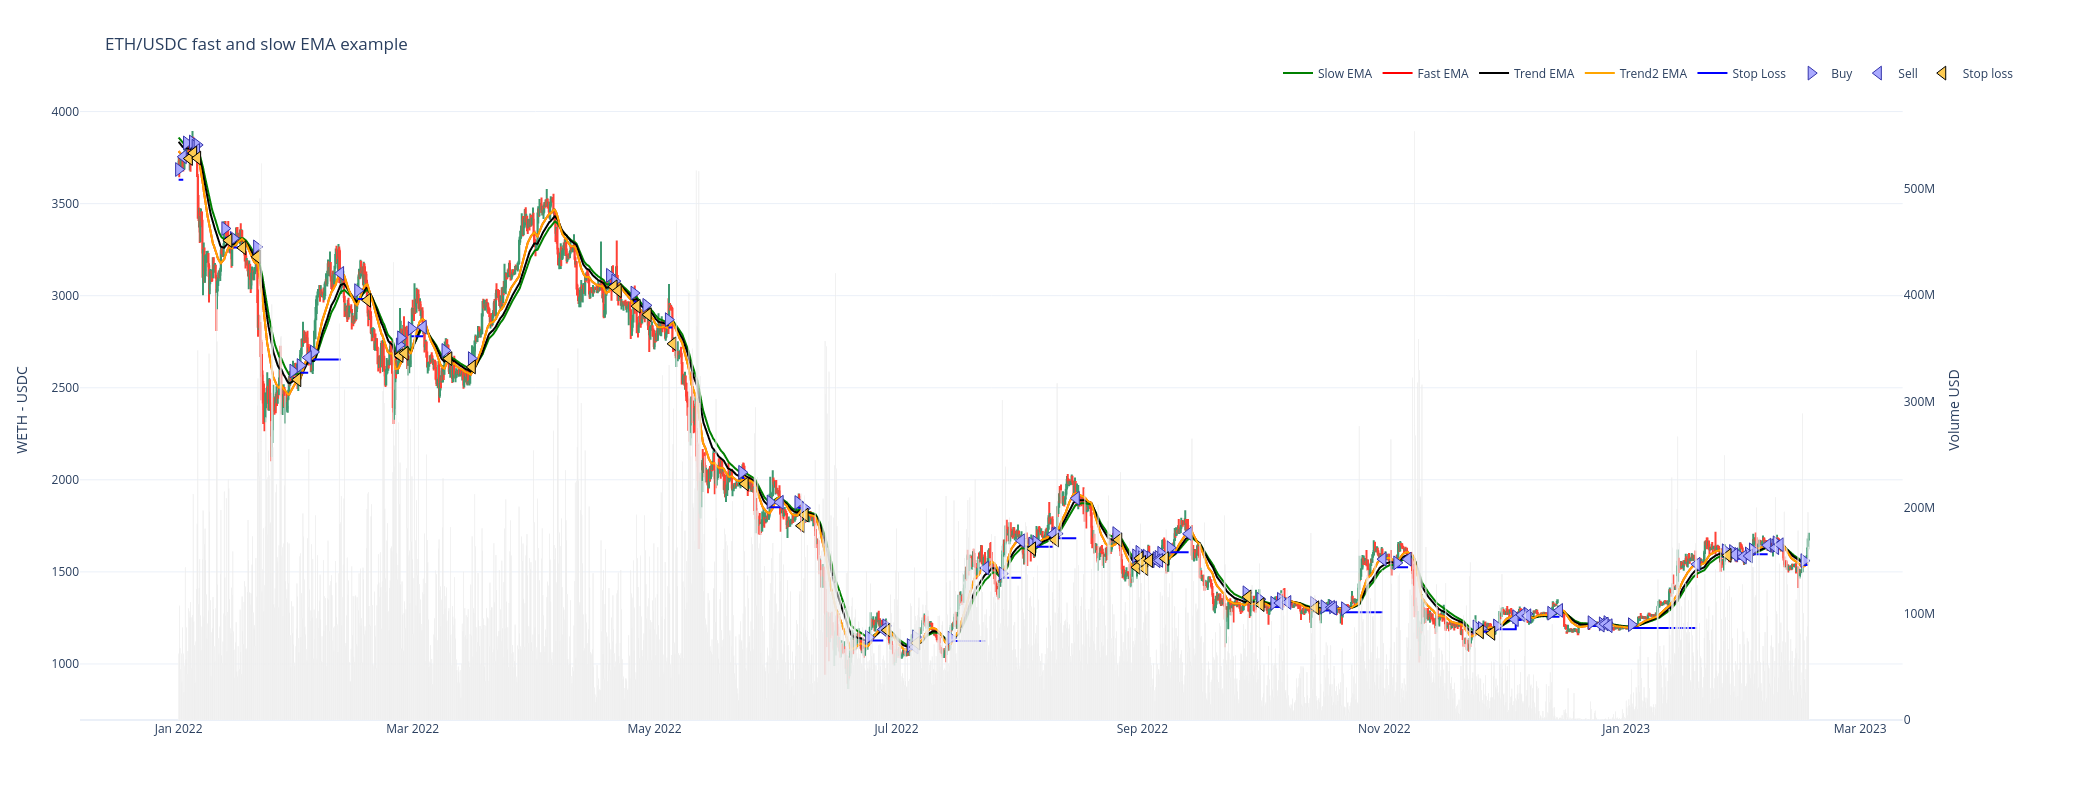

In [9]:
from tradeexecutor.visual.single_pair import visualise_single_pair

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=START_AT,
    end_at=END_AT)

figure.show()

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset


In [10]:
close = universe.universe.candles.get_single_pair_data()["close"]

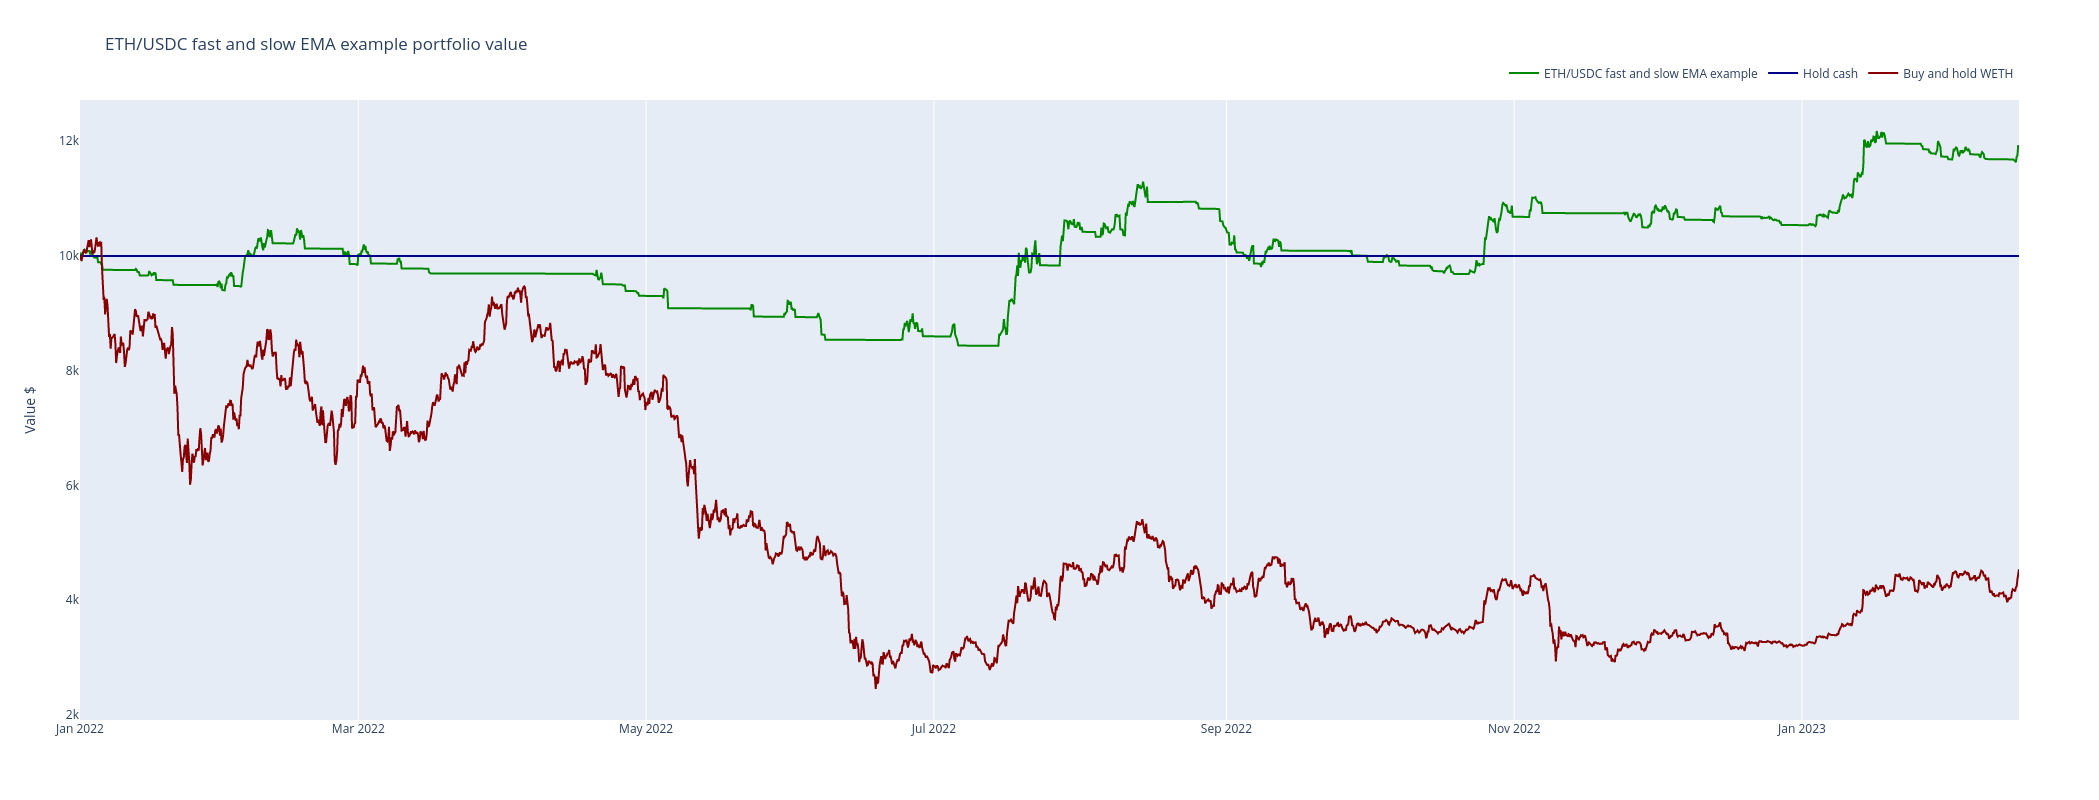

In [11]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [12]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance



In [13]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

0
Trading period length                      409 days
Return %                                     16.88%
Annualised return %                          15.03%
Cash at start                            $10,000.00
Value at end                             $11,687.86
Trade volume                            $743,822.79
Trade win percent                            23.29%
Total trades done                                73
Won trades                                       17
Lost trades                                      56
Stop losses triggered                            37
Stop loss % of all                           50.68%
Stop loss % of lost                          66.07%
Take profits triggered                            0
Take profit % of all                          0.00%
Take profit % of win                          0.00%
Zero profit trades                                0
Positions open at the end                         1
Realised profit and loss                  $1,687.86
Portfolio unrealised value                $5,843.93
Extra returns on lending pool interest        $0.00
Cash left at the end                      $5,843.93
Average winning trade profit %                8.27%
Average losing trade loss %                  -1.83%
Biggest winning trade %                      33.19%
Biggest losing trade %                       -6.83%
Average duration of winning trades           5 days
Average duration of losing trades            0 days
LP fees paid                                $372.00
LP fees paid % of volume                      0.05%
Average trade:                                0.53%
Median trade:                                -1.65%
Consecutive wins                                  2
Consecutive losses                               11
Biggest realized risk                        -3.41%
Avg realised risk                            -0.91%
Max pullback of total capital               -15.57%
Max loss risk at opening of position          0.77%

### Position and trade timeline

Display all positions and how much profit they made.

In [14]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [15]:
print("All ok")

All ok
